# Imports

In [1]:
# imports
import numpy as np
import torch
from tueplots import bundles, figsizes
import wandb
import matplotlib.pyplot as plt

import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [2]:
from analysis import sweep2df, learning_stats,corrected_jacobian_stats,correct_ica_scale_permutation, RED, BLUE


In [3]:
plt.rcParams.update(bundles.neurips2022(usetex=True))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/_collections_abc.py:834: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [182]:
# Constants
ENTITY = "causal-representation-learning"
PROJECT = "nl-causal-representations"

# W&B API
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

# Data loading

## 3D SEM

In [183]:
SWEEP_ID = "9b8ibcef"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_3d_munkres_sweep_{SWEEP_ID}"
df3d, (true_unmix_jacobians3d, est_unmix_jacobians3d, permute_indices3d, hsic_adj3d, ica_permute3d) = sweep2df(sweep.runs, filename, save=True, load=False)

In [ ]:
SWEEP_ID = "f6c2fdfr"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_3d_permute_sweep_{SWEEP_ID}"
df3d_permute, (true_unmix_jacobians3d_permute, est_unmix_jacobians3d_permute, permute_indices3d_permute, hsic_adj3d_permute, ica_permute3d_permute) = sweep2df(sweep.runs, filename, save=True, load=False)

In [ ]:
SWEEP_ID = "tpkxr1kj"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_3d_sparse_sweep_{SWEEP_ID}"
df3d_sparse, (true_unmix_jacobians3d_sparse, est_unmix_jacobians3d_sparse, permute_indices3d_sparse,hsic_adj_monti_variant) = sweep2df(sweep.runs, filename, save=True, load=True)

## 5D SEM

In [184]:
SWEEP_ID = "tzigp5kf"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_5d_munkres_sweep_{SWEEP_ID}"
df5d, (true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, hsic_adj5d, ica_permute5d) = sweep2df(sweep.runs, filename, save=True, load=False)

In [ ]:
SWEEP_ID = "6cqs4k9t"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_5d_permute_sweep_{SWEEP_ID}"
df5d_permute, (true_unmix_jacobians5d_permute, est_unmix_jacobians5d_permute, permute_indices5d_permute, hsic_adj5d_permute, ica_permute5d_permute) = sweep2df(sweep.runs, filename, save=True, load=False)

In [80]:
SWEEP_ID = "5vz4ttci"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_5d_sparse_sweep_{SWEEP_ID}"
df5d_sparse, (true_unmix_jacobians5d_sparse, est_unmix_jacobians5d_sparse, permute_indices5d_sparse,hsic_adj5d_sparse, ica_permute5d_sparse) = sweep2df(sweep.runs, filename, save=True, load=False)

Encountered a faulty run with ID crimson-sweep-5


## 8D SEM

In [ ]:
SWEEP_ID = "v2du3d05"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_8d_munkres_sweep_{SWEEP_ID}"
df8d, (true_unmix_jacobians8d, est_unmix_jacobians8d, permute_indices8d, hsic_adj8d, ica_permute8d) = sweep2df(sweep.runs, filename, save=True, load=False)

In [ ]:
SWEEP_ID = "si6590ko"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_8d_permute_sweep_{SWEEP_ID}"
df8d_permute, (true_unmix_jacobians8d_permute, est_unmix_jacobians8d_permute, permute_indices8d_permute, hsic_adj8d_permute, ica_permute8d_permute) = sweep2df(sweep.runs, filename, save=True, load=True)

In [ ]:
SWEEP_ID = "633i812f"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_8d_sparse_sweep_{SWEEP_ID}"
df8d_sparse, (true_unmix_jacobians8d_sparse, est_unmix_jacobians8d_sparse, permute_indices8d_sparse,hsic_adj8d_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

## 10D SEM

In [ ]:
SWEEP_ID = "hwapefxy"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_10d_munkres_sweep_{SWEEP_ID}"
df10d, (true_unmix_jacobians10d, est_unmix_jacobians10d, permute_indices10d, hsic_adj10d, ica_permute10d) = sweep2df(sweep.runs, filename, save=True, load=False)

In [ ]:
SWEEP_ID = "ku9wl27d"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_10d_sweep_{SWEEP_ID}"
df10d_permute, (true_unmix_jacobians10d_permute, est_unmix_jacobians10d_permute, permute_indices10d_permute, hsic_adj10d_permute, ica_permute10d_permute) = sweep2df(sweep.runs, filename, save=True, load=True)

In [ ]:
SWEEP_ID = "mdaej8aj"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_10d_sparse_sweep_{SWEEP_ID}"
df10d_sparse, (true_unmix_jacobians10d_sparse, est_unmix_jacobians10d_sparse, permute_indices10d_sparse,hsic_adj10d_sparse) = sweep2df(sweep.runs, filename, save=True, load=True)

## 15D SEM

In [ ]:
SWEEP_ID = "w7517p57"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"sem_15d_sweep_{SWEEP_ID}"
df15d, (true_unmix_jacobians15d, est_unmix_jacobians15d, permute_indices15d, hsic_adj15d, ica_permute15d) = sweep2df(sweep.runs, filename, save=True, load=False)

## MLP from Monti et al.

In [208]:
SWEEP_ID = "8tis6u9i"#"q99ne3vj" #"fhaza97x"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"monti_munkres_sweep_{SWEEP_ID}"
df_monti, (true_unmix_jacobians_monti, est_unmix_jacobians_monti, permute_indices_monti, hsic_adj_mont, ica_permute_monti) = sweep2df(sweep.runs, filename, save=True, load=False)

## Monti variants

In [ ]:
SWEEP_ID = "okewq6t1"#"70zssxmx"
sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
filename = f"monti_sparse_sweep_{SWEEP_ID}"
df_monti_variant, (true_unmix_jacobians_monti_variant, est_unmix_jacobians_monti_variant, permute_indices_monti_variant, hsic_adj_monti_variant) = sweep2df(sweep.runs, filename, save=True, load=True)

# Pre-processing


## Corrected stats

### 3D SEM

In [203]:
stats3d=corrected_jacobian_stats(df3d, true_unmix_jacobians3d, est_unmix_jacobians3d, permute_indices3d, hsic_adj3d, ica_permute3d)

----------------------------------
dim=3 (nonlin_sem=True)	MCC=0.969+0.098	  Acc:0.956+0.133	Acc (HSIC):0.611+0.167	SHD:0.044444+0.133333	[10 items]
----------------------------------
dim=3 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:1.000+0.000	Acc (HSIC):0.578+0.156	SHD:0.000000+0.000000	[10 items]


### 5D SEM

In [202]:
stats5d=corrected_jacobian_stats(df5d, true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, hsic_adj5d, ica_permute5d)

----------------------------------
dim=5 (nonlin_sem=True)	MCC=0.960+0.079	  Acc:0.884+0.160	Acc (HSIC):0.662+0.071	SHD:0.115556+0.160493	[9 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=0.969+0.066	  Acc:0.928+0.131	Acc (HSIC):0.648+0.104	SHD:0.072000+0.131210	[10 items]


In [91]:
stats5d_sparse=corrected_jacobian_stats(df5d_sparse, true_unmix_jacobians5d_sparse, est_unmix_jacobians5d_sparse, permute_indices5d_sparse, hsic_adj5d_sparse, ica_permute5d_sparse)

----------------------------------
dim=5 (nonlin_sem=True)	MCC=1.000+0.000	  Acc:0.760+0.051	Acc (HSIC):0.496+0.032	SHD:0.184000+0.040792	[5 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:0.820+0.066	Acc (HSIC):0.480+0.063	SHD:0.220000+0.044721	[4 items]


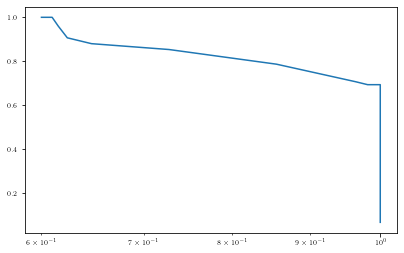

In [96]:
# plt.plot()
plt.semilogx(stats5d_sparse[5][True]["precisions"], stats5d_sparse[5][True]["recalls"])

### 8D SEM

In [227]:
stats8d=corrected_jacobian_stats(df8d, true_unmix_jacobians8d, est_unmix_jacobians8d,permute_indices8d,hsic_adj8d, ica_permute8d)

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=8 (nonlin_sem=True)	MCC=0.978+0.031	  Acc:0.840+0.210	Acc (HSIC):0.670+0.074	SHD:0.160156+0.209886	[8 items]
----------------------------------
dim=8 (nonlin_sem=False)	MCC=1.000+0.000	  Acc:1.000+0.000	Acc (HSIC):0.606+0.064	SHD:0.000000+0.000000	[10 items]


### 10D SEM

In [200]:
stats10d=corrected_jacobian_stats(df10d, true_unmix_jacobians10d, est_unmix_jacobians10d,permute_indices10d, hsic_adj10d, ica_permute10d)

----------------------------------
dim=10 (nonlin_sem=True)	MCC=0.947+0.001	  Acc:0.473+0.041	Acc (HSIC):0.652+0.042	SHD:0.526667+0.041096	[6 items]
----------------------------------
dim=10 (nonlin_sem=False)	MCC=0.956+0.027	  Acc:0.790+0.173	Acc (HSIC):0.587+0.061	SHD:0.210000+0.172916	[8 items]


### 15D SEM

In [195]:
stats15d=corrected_jacobian_stats(df15d, true_unmix_jacobians15d, est_unmix_jacobians15d, permute_indices15d, hsic_adj15d, ica_permute15d)

----------------------------------
dim=15 (nonlin_sem=True)	MCC=0.749+0.051	  Acc:0.653+0.027	Acc (HSIC):0.938+0.004	SHD:0.346667+0.026667	[2 items]
----------------------------------
dim=15 (nonlin_sem=False)	MCC=0.758+nan	  Acc:0.627+0.000	Acc (HSIC):0.902+0.000	SHD:0.373333+0.000000	[1 items]


### MLP from Monti et al.

In [209]:
stats_monti=corrected_jacobian_stats(df_monti, true_unmix_jacobians_monti, est_unmix_jacobians_monti, permute_indices_monti, hsic_adj_mont, ica_permute_monti, selector_col="n_mixing_layer")

----We need to figure out whether HSIC needs to be corrected--------
----------------------------------
dim=6 (n_mixing_layer=3)	MCC=0.999+nan	  Acc:1.000+0.000	Acc (HSIC):0.778+0.000	SHD:0.000000+0.000000	[1 items]
----------------------------------
dim=6 (n_mixing_layer=2)	MCC=0.999+nan	  Acc:1.000+0.000	Acc (HSIC):0.583+0.000	SHD:0.000000+0.000000	[1 items]
----------------------------------
dim=6 (n_mixing_layer=1)	MCC=1.000+0.000	  Acc:0.926+0.052	Acc (HSIC):0.519+0.073	SHD:0.055556+0.045361	[3 items]


### Monti variants

In [47]:
stats_monti_variant=corrected_jacobian_stats(df_monti_variant, true_unmix_jacobians_monti_variant, est_unmix_jacobians_monti_variant,permute_indices_monti_variant, hsic_adj_monti_variant,selector_col="n_mixing_layer")

----------------------------------
dim=6 (n_mixing_layer=5)	MCC=0.857+0.025	  Acc:0.728+0.027	Acc (HSIC):0.461+0.065	SHD:0.272222+0.027217	[5 items]
----------------------------------
dim=6 (n_mixing_layer=4)	MCC=0.857+0.023	  Acc:0.717+0.067	Acc (HSIC):0.456+0.048	SHD:0.283333+0.066667	[5 items]
----------------------------------
dim=6 (n_mixing_layer=3)	MCC=0.916+0.072	  Acc:0.656+0.089	Acc (HSIC):0.489+0.116	SHD:0.344444+0.088889	[5 items]
----------------------------------
dim=6 (n_mixing_layer=2)	MCC=0.996+0.000	  Acc:0.689+0.087	Acc (HSIC):0.483+0.062	SHD:0.311111+0.086781	[5 items]
----------------------------------
dim=6 (n_mixing_layer=1)	MCC=0.996+0.000	  Acc:0.706+0.103	Acc (HSIC):0.417+0.030	SHD:0.294444+0.100308	[5 items]


## Learning permutations

### 3D SEM

In [305]:
learning_stats(df3d, true_unmix_jacobians3d, est_unmix_jacobians3d, permute_indices3d)

----------------------------------
----------------------------------
dim=3 (nonlin_sem=False)	MCC=1.000+0.000	Acc(order):1.000	  Acc:1.000	SHD:0.000000	[27 items]
----------------------------------
----------------------------------
----------------------------------
----------------------------------
dim=3 (nonlin_sem=True)	MCC=1.000+0.000	Acc(order):1.000	  Acc:1.000	SHD:0.000000	[13 items]
----------------------------------
----------------------------------


### 5D SEM

In [306]:
learning_stats(df5d, true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, 1e-3)

----------------------------------
----------------------------------
dim=5 (nonlin_sem=True)	MCC=0.971+0.065	Acc(order):0.828	  Acc:0.974	SHD:0.026207	[29 items]
----------------------------------
----------------------------------
----------------------------------
----------------------------------
dim=5 (nonlin_sem=False)	MCC=1.000+0.000	Acc(order):0.966	  Acc:0.999	SHD:0.001379	[29 items]
----------------------------------
----------------------------------


In [71]:
learning_stats(df5d, true_unmix_jacobians5d, est_unmix_jacobians5d, permute_indices5d, 1e-3, dag_permute=False)

----------------------------------
dim=5 (nonlin_sem=True)	MCC=1.000+0.000	Acc(order):0.000	  Acc:0.962	SHD:0.038462	[26 items]
----------------------------------
dim=5 (nonlin_sem=False)	MCC=1.000+0.000	Acc(order):0.000	  Acc:0.982	SHD:0.017778	[27 items]


### 8D SEM

In [225]:
learning_stats(df8d, true_unmix_jacobians8d, est_unmix_jacobians8d, permute_indices8d, 1e-3)

----------------------------------
dim=8 (nonlin_sem=True)	MCC=0.978+0.031	Acc(order):0.625	  Acc:0.945	SHD:0.054688	[8 items]
----------------------------------
dim=8 (nonlin_sem=False)	MCC=1.000+0.000	Acc(order):1.000	  Acc:1.000	SHD:0.000000	[10 items]


### 10D SEM

In [308]:
learning_stats(df10d, true_unmix_jacobians10d, est_unmix_jacobians10d, permute_indices10d, 1e-3)

----------------------------------
dim=10 (nonlin_sem=True)	MCC=0.944+0.032	Acc(order):0.067	  Acc:0.839	SHD:0.161333	[30 items]
----------------------------------
dim=10 (nonlin_sem=False)	MCC=0.985+0.027	Acc(order):0.767	  Acc:0.969	SHD:0.030667	[30 items]


### MLP from Monti et al.

In [309]:
learning_stats(df_monti, true_unmix_jacobians_monti, est_unmix_jacobians_monti, permute_indices_monti, selector_col="n_mixing_layer", weight_threshold=None, hamming_threshold=1e-3, dag_permute=False)

----------------------------------
dim=6 (n_mixing_layer=5)	MCC=0.848+0.020	Acc(order):0.000	  Acc:0.839	SHD:0.161111	[5 items]
----------------------------------
dim=6 (n_mixing_layer=4)	MCC=0.833+0.014	Acc(order):0.000	  Acc:0.817	SHD:0.183333	[5 items]
----------------------------------
dim=6 (n_mixing_layer=3)	MCC=0.932+0.087	Acc(order):0.000	  Acc:0.900	SHD:0.100000	[5 items]
----------------------------------
dim=6 (n_mixing_layer=2)	MCC=0.999+0.000	Acc(order):0.000	  Acc:1.000	SHD:0.005556	[5 items]
----------------------------------
dim=6 (n_mixing_layer=1)	MCC=1.000+0.000	Acc(order):0.000	  Acc:1.000	SHD:0.000000	[5 items]


# Plots

## Corrected stats

### Nonlinear

In [211]:
"""NL"""
selector = False

metric = "thresholds"
thresholds = torch.stack([stats3d[3][selector][metric], stats5d[5][selector][metric],stats8d[8][selector][metric],stats10d[10][selector][metric]])

metric = "precisions"
precisions_nl = torch.stack([stats3d[3][selector][metric], stats5d[5][selector][metric],stats8d[8][selector][metric],stats10d[10][selector][metric]])

metric = "recalls"
recalls_nl = torch.stack([stats3d[3][selector][metric], stats5d[5][selector][metric],stats8d[8][selector][metric],stats10d[10][selector][metric]])

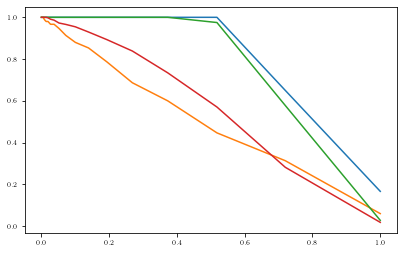

In [212]:
plt.plot(thresholds.T, recalls_nl.T)

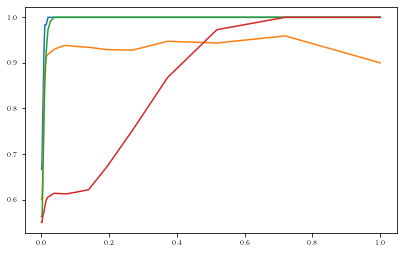

In [213]:
plt.plot(thresholds.T, precisions_nl.T)

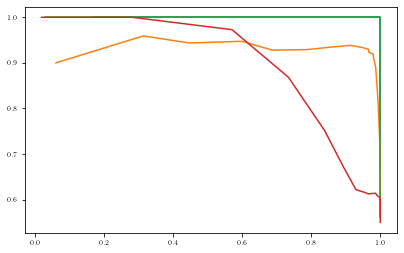

In [218]:
plt.plot(recalls_nl.T, precisions_nl.T)

### Linear

In [219]:
"""Linear"""
selector = True

# thresholds are the same

metric = "precisions"
precisions_lin = torch.stack([stats3d[3][selector][metric], stats5d[5][selector][metric],stats8d[8][selector][metric],stats10d[10][selector][metric]])

metric = "recalls"
recalls_lin = torch.stack([stats3d[3][selector][metric], stats5d[5][selector][metric],stats8d[8][selector][metric],stats10d[10][selector][metric]])

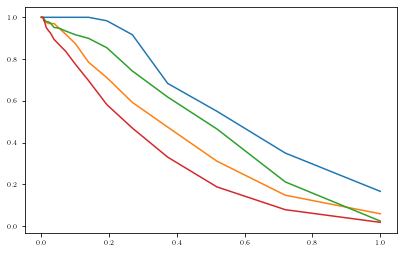

In [220]:
plt.plot(thresholds.T, recalls_lin.T)

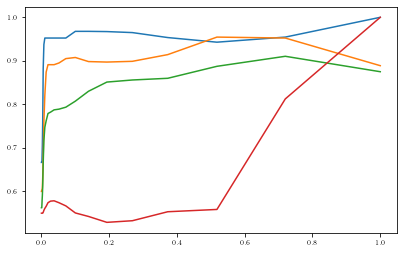

In [222]:
plt.plot(thresholds.T, precisions_lin.T)

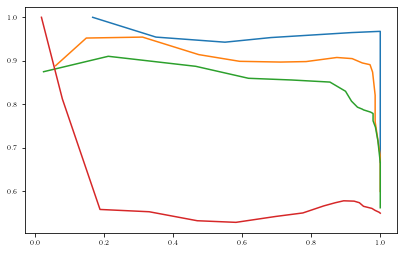

In [224]:
plt.plot(recalls_lin.T,precisions_lin.T)

### Both

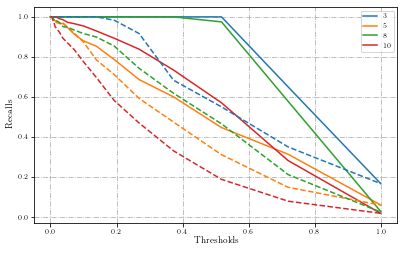

In [221]:
TICK_PADDING = 2
LABELPAD = 3
DIMS = [3,5,8,10]
COLORS = ["tab:blue","tab:orange","tab:green","tab:red"]


fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=1)['figure.figsize'])

ax = fig.add_subplot(111)
ax.grid(True, which="both", ls="-.")
ax.set_axisbelow(True)

for rec_nl, c in zip(recalls_nl, COLORS):
    im = ax.plot(thresholds[0,:], rec_nl, c=c)
for rec_lin, c in zip(recalls_lin, COLORS):
    im = ax.plot(thresholds[0,:], rec_lin, c=c, ls="--")
# ax.plot(np.linspace(.85, 6), -np.linspace(.85, 6), c="black", label='$y=x^{-2}$')
ax.set_ylabel("Recalls", labelpad=LABELPAD)
ax.set_xlabel("Thresholds", labelpad=LABELPAD)
plt.legend(DIMS)
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)

# ax = fig.add_subplot(122)
# ax.grid(True, which="both", ls="-.")
# ax.set_axisbelow(True)

# im = ax.plot(thresholds.T, recalls_lin.T, ls="--", c=COLORS)
# ax.plot(np.linspace(.85, 6), -np.linspace(.85, 6), c="black", label='$y=x^{-2}$')
# ax.set_ylabel("Recalls (Lin)", labelpad=LABELPAD)
ax.set_xlabel("Thresholds", labelpad=LABELPAD)
plt.legend(DIMS)
ax.tick_params(axis='both', which='major', pad=TICK_PADDING)

plt.savefig("recalls.svg")

## Hinton diagram

In [ ]:
# Source: https://matplotlib.org/3.1.1/gallery/specialty_plots/hinton_demo.html

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))


    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = BLUE if w > 0 else RED
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()

In [260]:
from notebooks.analysis import perm2matrix

In [249]:
idx = -1
j_est = est_unmix_jacobians3d[idx]
j_gt = true_unmix_jacobians3d[idx]
j_p= permute_indices3d[idx]
j_pm= perm2matrix(j_p)
# j_gt_p = j_pm.numpy() @ j_gt
j_est_corr = correct_ica_scale_permutation(torch.from_numpy(j_est.astype(np.float32)),j_pm,torch.from_numpy(j_gt.astype(np.float32))).numpy()

In [250]:
j_est_corr

array([[ 1.5320351 , -0.01130555, -0.00469695],
       [ 1.5820673 ,  1.8025558 , -0.01033536],
       [ 1.96809   ,  1.4212089 ,  1.5321796 ]], dtype=float32)

In [318]:
true_unmix_jacobians_monti

[array([[ 0.00252052,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.01277678,  0.00205859,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.03138999, -0.01081219,  0.0021257 ,  0.        ,  0.        ,
          0.        ],
        [-0.07721966,  0.03315201, -0.01093221,  0.00156558,  0.        ,
          0.        ],
        [ 0.14143941, -0.06895113,  0.02950584, -0.00946515,  0.00222511,
          0.        ],
        [-0.20769876,  0.10927062, -0.05303581,  0.02336621, -0.00951978,
          0.0020853 ]]),
 array([[ 0.00163575,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.00963337,  0.00209877,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.02328577, -0.00941281,  0.00175942,  0.        ,  0.        ,
          0.        ],
        [-0.04222301,  0.02079622, -0.00729232,  0.00161148,  0.        ,
          0.        ],
        [ 0.06250732, -0.036